# V. Landmark-based Localization and mapping. 
## Section A. Localization with error-state Kalman filter on manifold
Based on the [paper](https://arxiv.org/abs/1812.01537) by Sola and [manifpy](https://artivis.github.io/manif/python/) examples. 

In [42]:
from manifpy import SE2, SE2Tangent
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv

In [43]:
# START CONFIGURATION

NUMBER_OF_LMKS_TO_MEASURE = 3

# Define the robot pose element and its covariance
X_simulation = SE2.Identity()
X = SE2.Identity()
X_unfiltered = SE2.Identity()
P = np.zeros((3, 3))

u_nom = np.array([0.1, 0.0, 0.05])
u_sigmas = np.array([0.1, 0.1, 0.1])
U = np.diagflat(np.square(u_sigmas))

# Declare the Jacobians of the motion wrt robot and control
J_x = np.zeros((3, 3))
J_u = np.zeros((3, 3))

landmarks = np.array([
    [2.0,  0.0],
    [2.0,  1.0],
    [2.0, -1.0]
])

measurements = [np.array([0, 0])] * NUMBER_OF_LMKS_TO_MEASURE

y_sigmas = np.array([0.01, 0.01])
R = np.diagflat(np.square(y_sigmas))

J_xi_x = np.zeros((3, 3))
J_e_xi = np.zeros((2, 3))

In [44]:
np.set_printoptions(precision=3, suppress=True)

In [45]:
print('X STATE     :    X      Y      Z    TH_x   TH_y   TH_z ')
print('-------------------------------------------------------')
print('X initial   : ', X_simulation.log().coeffs())
print('-------------------------------------------------------')

X STATE     :    X      Y      Z    TH_x   TH_y   TH_z 
-------------------------------------------------------
X initial   :  [0. 0. 0.]
-------------------------------------------------------


In [46]:
X_simmed = np.zeros((10, 2))
X_ested = np.zeros((10, 2))

In [47]:
for t in range(10):
        # I. Simulation

        # simulate noise
        u_noise = u_sigmas * np.random.rand(SE2.DoF)        # control noise
        u_noisy = u_nom + u_noise                           # noisy control

        u_simu = SE2Tangent(u_nom)
        u_est = SE2Tangent(u_noisy)
        u_unfilt = SE2Tangent(u_noisy)

        # first we move
        X_simulation = X_simulation + u_simu                # overloaded X.rplus(u) = X * exp(u)

        # then we measure all landmarks
        for i in range(NUMBER_OF_LMKS_TO_MEASURE):
            b = landmarks[i]                                # lmk coordinates in world frame

            # simulate noise
            y_noise = y_sigmas * np.random.rand(SE2.Dim)    # measurement noise

            y = X_simulation.inverse().act(b)               # landmark measurement, before adding noise

            y = y + y_noise                                 # landmark measurement, noisy
            measurements[i] = y                             # store for the estimator just below

        # II. Estimation

        # First we move

        X = X.plus(u_est, J_x, J_u)                         # X * exp(u), with Jacobians

        P = J_x @ P @ J_x.transpose() + J_u @ U @ J_u.transpose()

        # Then we correct using the measurements of each lmk
        for i in range(NUMBER_OF_LMKS_TO_MEASURE):
            # landmark
            b = landmarks[i]                                # lmk coordinates in world frame

            # measurement
            y = measurements[i]                             # lmk measurement, noisy

            # expectation
            e = X.inverse(J_xi_x).act(b, J_e_xi)            # note: e = R.tr * ( b - t ), for X = (R,t).
            H = J_e_xi @ J_xi_x                             # Jacobian of the measurements wrt the robot pose. note: H = J_e_x = J_e_xi * J_xi_x
            E = H @ P @ H.transpose()

            # innovation
            z = y - e
            Z = E + R

            # Kalman gain
            K = P @ H.transpose() @ inv(Z)                  # K = P * H.tr * ( H * P * H.tr + R).inv

            # Correction step
            dx = K @ z                                      # dx is in the tangent space at X

            # Update
            X = X + SE2Tangent(dx)                          # overloaded X.rplus(dx) = X * exp(dx)
            P = P - K @ Z @ K.transpose()

        # III. Unfiltered

        # move also an unfiltered version for comparison purposes
        X_unfiltered = X_unfiltered + u_unfilt

        # IV. Results

        # DEBUG
        X_simmed[t, :] =  np.array([X_simulation.x(), X_simulation.y()])
        X_ested[t, :] =  np.array([X.x(), X.y()])
        print('X simulated : ', X_simulation.log().coeffs().transpose())
        print('X estimated : ', X.log().coeffs().transpose())
        print('X unfilterd : ', X_unfiltered.log().coeffs().transpose())
        print('-------------------------------------------------------')
        # END DEBUG


X simulated :  [0.1  0.   0.05]
X estimated :  [ 0.095 -0.005  0.049]
X unfilterd :  [0.132 0.089 0.108]
-------------------------------------------------------
X simulated :  [ 0.2 -0.   0.1]
X estimated :  [ 0.194 -0.005  0.1  ]
X unfilterd :  [0.274 0.155 0.215]
-------------------------------------------------------
X simulated :  [ 0.3  -0.    0.15]
X estimated :  [ 0.295 -0.012  0.152]
X unfilterd :  [0.438 0.172 0.268]
-------------------------------------------------------
X simulated :  [ 0.4 -0.   0.2]
X estimated :  [0.397 0.001 0.198]
X unfilterd :  [0.534 0.254 0.361]
-------------------------------------------------------
X simulated :  [0.5  0.   0.25]
X estimated :  [ 0.496 -0.01   0.252]
X unfilterd :  [0.684 0.331 0.485]
-------------------------------------------------------
X simulated :  [ 0.6 -0.   0.3]
X estimated :  [ 0.595 -0.003  0.299]
X unfilterd :  [0.819 0.414 0.555]
-------------------------------------------------------
X simulated :  [ 0.7  -0.    0.35]

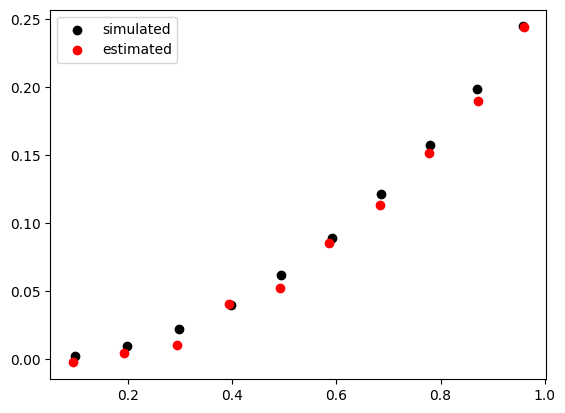

In [51]:
plt.figure()
plt.scatter(X_simmed[:, 0], X_simmed[:, 1], color='k', label='simulated')
plt.scatter(X_ested[:, 0], X_ested[:, 1], color='r', label='estimated')
# plt.scatter(landmarks[:, 0], landmarks[:, 1], color='y', marker='*', label='Landmarks')
plt.legend()
plt.show()